# Multidimensional PDEs


* Parabolic PDE here:
$$\frac{\partial f}{\partial t} = \alpha\frac{\partial^2 f}{\partial x^2} + \alpha\frac{\partial^2 f}{\partial y^2} + S.$$
* Create a two dimensional grid of $(i,\,j)$ points in the $x$ and $y$ directions.
* Take $S$ as constant in time.



## FTCS method

* Explicit
* $\mathcal{O}(\Delta t),$ $\mathcal{O}(\Delta x^2),$ $\mathcal{O}(\Delta y^2).$ 

$$f_{i,j}^{n+1} = f_{i,j}^n + 
\frac{\alpha\Delta t}{\Delta x^2}(f_{i-1,j}^n-2f_{i,j}^n+f_{i+1,j}^n) +
\frac{\alpha\Delta t}{\Delta y^2}(f_{i,j-1}^n-2f_{i,j}^n+f_{i,j+1}^n) +
\Delta tS_{i,j}.$$

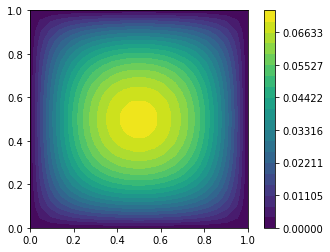

<Figure size 432x288 with 0 Axes>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
from IPython.display import display, clear_output

Lxy     = 1.0                 # domain length Lx=Ly
nTauRun = 0.2                 # number of intrinsic timescale to run for
nxy     = 22                  # number of grid points in x and y directions
α       = 1.0                 # thermal diffusivity
tFac    = 0.5                 # timestep size factor. 
         
tau  = Lxy**2/α               # diffusive timescale based on the whole domain.
tend = nTauRun*tau            # run time
dxy  = Lxy/(nxy-1)            # grid spacing in x and y directions
dt   = tFac*dxy**2*α/4        # timestep size
nt   = int(np.ceil(tend/dt))  # number of timesteps
nPlt = np.ceil(1/tFac)*10     # how often to plot

f = np.zeros((nxy,nxy))       # solution array
S = np.ones((nxy,nxy))        # source term array

X,Y = np.meshgrid(np.linspace(0,Lxy,nxy), np.linspace(0,Lxy,nxy))
i = np.arange(1,nxy-1)
j = np.arange(1,nxy-1)
ix = np.ix_

for it in range(nt):
    f[ix(i,j)] += α*dt/dxy**2*(f[ix(i-1,j)] - 2*f[ix(i,j)] + f[ix(i+1,j)]) + \
                  α*dt/dxy**2*(f[ix(i,j-1)] - 2*f[ix(i,j)] + f[ix(i,j+1)]) + \
                  dt*S[ix(i,j)]
    
    if it%nPlt==0:
        plt.clf()
        plt.contourf(X,Y,f,levels=np.linspace(0,dt*260,21))
        plt.colorbar()
        plt.gca().set_aspect('equal', adjustable='box')
        clear_output(wait=True)
        display(plt.gcf())
        time.sleep(0.1)
plt.clf()

## BTCS method

* Implicit
* $\mathcal{O}(\Delta t),$ $\mathcal{O}(\Delta x^2),$ $\mathcal{O}(\Delta y^2).$ 

$$f_{i,j}^{n+1} = f_{i,j}^n + 
\frac{\alpha\Delta t}{\Delta x^2}(f_{i-1,j}^{n+1}-2f_{i,j}^{n+1}+f_{i+1,j}^{n+1}) +
\frac{\alpha\Delta t}{\Delta y^2}(f_{i,j-1}^{n+1}-2f_{i,j}^{n+1}+f_{i,j+1}^{n+1}) +
\Delta tS_{i,j}.$$



* Rearrange this equation so that all $n+1$ terms are on the left-hand side (LHS) and all other terms are on the right-hand side (RHS):
* Let
$$d_x = \frac{\alpha\Delta t}{\Delta x^2},$$
$$d_y = \frac{\alpha\Delta t}{\Delta y^2}.$$
* Then,
$$
(d_y)f_{i,j-1}^{n+1} + 
(d_x)f_{i-1,j}^{n+1} + 
(-2d_x-2d_y-1)f_{i,j}^{n+1} + 
(d_x)f_{i+1,j}^{n+1} + 
(d_y)f_{i,j+1}^{n+1} =
-f_{i,j}^n - \Delta tS_{i,j}.
$$


* Or, in coefficient form:
<font color='blue'>
$$
(c)f_{i,j-1}^{n+1} + 
(u)f_{i-1,j}^{n+1} + 
(a)f_{i,j}^{n+1} + 
(u)f_{i+1,j}^{n+1} + 
(c)f_{i,j+1}^{n+1} =
b,$$
</font>
<font color='blue'>
$$c = d_y,$$
</font>
<font color='blue'>
$$u = d_x,$$
</font>
<font color='blue'>
$$a = -2d_x-2d_y-1,$$
</font>
<font color='blue'>
$$b= -f_{i,j}^n-\Delta tS_{i,j}.$$
</font>

* Alternative: if $d_x=d_y$, divide through by by $d_x$.
<font color='blue'>
$$
(c)f_{i,j-1}^{n+1} + 
(u)f_{i-1,j}^{n+1} + 
(a)f_{i,j}^{n+1} + 
(u)f_{i+1,j}^{n+1} + 
(c)f_{i,j+1}^{n+1} =
b,$$
</font>
<font color='blue'>
$$c = 1,$$
</font>
<font color='blue'>
$$u = 1,$$
</font>
<font color='blue'>
$$a = -4-\frac{1}{d},$$
</font>
<font color='blue'>
$$b= -\frac{f_{i,j}^n}{d}-\frac{\Delta tS_{i,j}}{d}.$$
</font>

### Matrix form
* Our unknowns are on a two-dimensional grid. 
* We need to arrange these in one-dimension for solution as a coupled linear system of equations.
<img src="https://ignite.byu.edu/che541/lectures/figs/l25f01.png" width="150">


* The points in the grid are numbered sequentially.
* Three types of cells:
    1. Corner
    2. Edge
    3. Interior
* As for 1-D problems, unknown points (cells that are not boundary cells) will refer to neighboring cells.
    * Corner and edge cells will refer to boundary cells due to the discretization stencils of the spatial derivatives in the PDE. 
    * These BC point will appear on the RHS of the $Ax=b$ linear system to be solved.
* ***Considering Dirichlet BCs.***    


#### Matrix structure:
<img src="https://ignite.byu.edu/che541/lectures/figs/l25f02.png" width="800">



* In the matrix shown, empty cells are zero.
* Note the explicit "O" points where boundary conditons have been moved from the $A$ matrix to the RHS vector $b$.
* Note the explicit "*" points have nonzero values in the matrix.
* Consider grid point 4:
    * It has neighbors: 3 and 8, so in row 4, there are *'s in columns 3, 4, and 8.
    * The "O" in column 5 arises since point 5 is not a neighbor of point 4 and does not appear in point 4's discretization stencil.
    * Instead, point 4's right neighbor is a boundary point, and this boundary augments the 4$^{th}$ element of the $b$ vector. Similarly for the point on the boundary below point 4.


#### Here is the matrix in terms of coefficients:
<img src="https://ignite.byu.edu/che541/lectures/figs/l25f03.png" width="800">



* Note, this is on a grid where the indicies of the unknowns start at 1. 
    * Here, point $(i,\,j)$ is unknown number $i+(j-1)\cdot n_x$, where $n_x$ is the number of points in the $x$ direction (4 in the example above).
    * On a grid where the indicies of the unknowns start at 0 (as in Python), we would have point $(i,\,j)$ in the grid corresponds to point $i+j\cdot n_x$ in the list of unknowns.